 <font size="7">Airport Simulation</font>

**Author: Adarsh Anand**
<br>Roll No. 2003101
<br>B.Tech. CSE 2020

Date: 23 April 2022

In [1]:
# importing the libraries
import simpy
import random
from functools import partial, wraps
import matplotlib.pyplot as plt
import seaborn as sns

# 1 unit of simpy time = 1 minute


# Global variables
foreignCounter = 2
localCounter = 2

localCounterTime = (0.5, 2)
foreignCounterTime = (2, 3)

numOfPeople = (100, 200)

timeOfSimultion = 24*60

walkingTime = (5, 10)


 <font size="5"> Simpy Simulation of Immigration </font>

 **Q1. Part A & Part B**

Flight 1 arrived at 19.31
Time:24.34 Passenger 101 from flight 1 arrived in queue.
Time:24.34 Passenger 101 arrived at local counter.
Time:24.37 Passenger 159 from flight 1 arrived in queue.
Time:24.37 Passenger 159 arrived at foreign counter.
Time:24.37 Passenger 37 from flight 1 arrived in queue.
Time:24.37 Passenger 37 arrived at local counter.
Time:24.37 Passenger 64 from flight 1 arrived in queue.
Time:24.38 Passenger 131 from flight 1 arrived in queue.
Time:24.38 Passenger 131 arrived at foreign counter.
Time:24.41 Passenger 0 from flight 1 arrived in queue.
Time:24.44 Passenger 126 from flight 1 arrived in queue.
Time:24.48 Passenger 55 from flight 1 arrived in queue.
Time:24.49 Passenger 5 from flight 1 arrived in queue.
Time:24.59 Passenger 47 from flight 1 arrived in queue.
Time:24.60 Passenger 35 from flight 1 arrived in queue.
Time:24.69 Passenger 143 from flight 1 arrived in queue.
Time:24.69 Passenger 44 from flight 1 arrived in queue.
Time:24.69 Passenger 72 from flight 

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

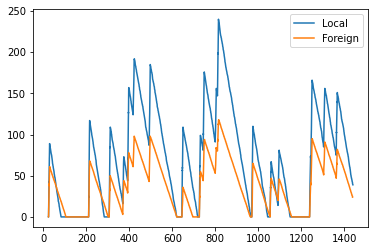

In [2]:
localPassenger = 0
foreignPassenger = 0

foreign_queue = []
local_queue = []

# Flight arrival generator using Poisson Distribution
def flight_arrival(env):
    global flight_arrived
    while True:
        yield env.timeout(random.expovariate(1/60))
        flight_arrived.succeed()
        flight_arrived = simpy.Event(env)

# Passenger class
class Passenger:
    global local_counters, foreign_counters
    def __init__(self, env, type, flight_num, i):
        self.env = env
        self.type = type
        self.id = i
        self.flight_id = flight_num
        env.process(self.Behaviour())
    
    # Passenger Behaviour on basis of local/foreigner
    def Behaviour(self):
        yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
        print("Time:%.2f" % self.env.now, "Passenger", self.id, "from flight", self.flight_id, "arrived in queue.")
        if (self.type == "local"):
            yield self.env.process(self.localCustomerArrival())
        else:
            yield self.env.process(self.foreignCustomerArrival())

    # If Passenger is local
    def localCustomerArrival(self):
        global localPassenger, foreignPassenger, W_local, W_foreign
        # wait for local counter to get free
        with local_counters.request() as req:
            wait_time_start = self.env.now
            yield req
            W_local += self.env.now - wait_time_start
            print("Time:%.2f" % self.env.now, "Passenger", self.id, "arrived at local counter.")
            localPassenger += 1
            yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
            # local Passenger is done immigration
            print("Time:%.2f" % self.env.now, "Passenger", self.id, "done immigration.")

    # if Passenger is foreign
    def foreignCustomerArrival(self):
        global localPassenger, foreignPassenger, W_local, W_foreign
        # wait for foreign counter to get free
        with foreign_counters.request() as req:
            wait_time_start = self.env.now
            yield req
            W_foreign += self.env.now - wait_time_start
            print("Time:%.2f" % self.env.now, "Passenger", self.id, "arrived at foreign counter.")
            foreignPassenger += 1
            yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
            print("Time:%.2f" % self.env.now, "Passenger", self.id, "done immigration.")
        

# Generator function to generate passengers on flight arrival
def flight_passengers(env):
    global W_local, W_foreign, localPassenger, foreignPassenger
    flight_num = 0
    while True:
        flight_num += 1
        # wait for flight to arrive
        yield flight_arrived
        print("Flight", flight_num, "arrived at %.2f" % env.now)

        # generate passengers 
        passengers_count = random.randint(numOfPeople[0], numOfPeople[1])
        for i in range(passengers_count):
            # generate local/foreign Passenger on basis of probability
            P_Local = random.uniform(0, 1)
            if (P_Local < 2/3):
                Passenger_type = "local"
            else:
                Passenger_type = "foreign"
            Passenger(env, Passenger_type, flight_num, i)

# Create simpy environment
env = simpy.Environment()

W_local = 0
W_foreign = 0

# Monitored Resource class to keep track of local and foreign queue lengths
# from https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#resource-usage

class MonitoredResource(simpy.Resource):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = []

    def request(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))
        return super().request(*args, **kwargs)

    def release(self, *args, **kwargs):
        self.data.append((self._env.now, len(self.queue)))
        return super().release(*args, **kwargs)

# Create local and foreign counters
foreign_counters = MonitoredResource(env, capacity=foreignCounter)
local_counters = MonitoredResource(env, capacity=localCounter)

flight_arrived = simpy.Event(env)

passengers_flight_proc = env.process(flight_passengers(env))
flight_arrival_proc = env.process(flight_arrival(env))

env.run(until=timeOfSimultion)

time_local = []
time_foreign = []

for i in range(len(local_counters.data)):
    time_local.append(local_counters.data[i][0])
    local_queue.append(local_counters.data[i][1])

for i in range(len(foreign_counters.data)):
    time_foreign.append(foreign_counters.data[i][0])
    foreign_queue.append(foreign_counters.data[i][1])


# print(W_local/localPassenger)
# print(W_foreign/foreignPassenger)

# Plotting instantaneous queue length for m=n=2, over one single day
sns.lineplot(time_local, local_queue, label="Local")
sns.lineplot(time_foreign, foreign_queue, label="Foreign")
plt.show()

**Observations:**<br>
1. Queue lengths for local passengers remain higher than foreign passengers. 
2. Distribution of queue lengths vary a lot over days since we are only considering 24 flights per day and the poisson distribution may cause 2 flights to arrive very close or very far sometimes

**Part 3:**

In [3]:
# Creating lists to store W for different number of simulation runs

Local_avg_100 = []
Foreign_avg_100 = []

Local_avg_400 = []
Foreign_avg_400 = []

Local_avg_1600 = []
Foreign_avg_1600 = []


**Simulation for n = 100**

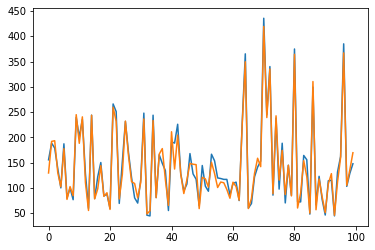

In [4]:
# Same as part a but with different number of simulation runs
# Commented out print statements to save time and space
for i in range(100):

    def flight_arrival(env):
        global flight_arrived
        while True:
            yield env.timeout(random.expovariate(1/60))
            flight_arrived.succeed()
            flight_arrived = simpy.Event(env)
            # yield env.process(flight_arrival(env))


    class Passenger:
        global local_counters, foreign_counters

        def __init__(self, env, type, flight_num, i):
            self.env = env
            self.type = type
            self.id = i
            self.flight_id = flight_num
            env.process(self.Behaviour())

        def Behaviour(self):
            yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
            # print("Time:%.2f" % self.env.now, "Passenger", self.id,
            #     "from flight", self.flight_id, "arrived in queue.")
            if (self.type == "local"):
                yield self.env.process(self.localCustomerArrival())
            else:
                yield self.env.process(self.foreignCustomerArrival())
            # yield self.env.process(self.counter_arrival(self.env))

        def localCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with local_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_local += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at local counter.")
                localPassenger += 1
                yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")

        def foreignCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with foreign_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_foreign += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at foreign counter.")
                foreignPassenger += 1
                yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")


    def flight_passengers(env):
        global W_local, W_foreign, localPassenger, foreignPassenger
        flight_num = 0
        while True:
            flight_num += 1
            yield flight_arrived
            # print("Flight", flight_num, "arrived at %.2f" % env.now)

            passengers_count = random.randint(
                numOfPeople[0], numOfPeople[1])
            for i in range(passengers_count):
                P_Local = random.uniform(0, 1)
                if (P_Local < 2/3):
                    Passenger_type = "local"
                else:
                    Passenger_type = "foreign"
                Passenger(env, Passenger_type, flight_num, i)


    env = simpy.Environment()

    W_local = 0
    W_foreign = 0


    localPassenger = 0
    foreignPassenger = 0

    foreign_queue = []
    local_queue = []


    class MonitoredResource(simpy.Resource):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.data = []

        def request(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().request(*args, **kwargs)

        def release(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().release(*args, **kwargs)


    foreign_counters = MonitoredResource(env, capacity=foreignCounter)
    local_counters = MonitoredResource(env, capacity=localCounter)

    flight_arrived = simpy.Event(env)

    passengers_flight_proc = env.process(flight_passengers(env))
    flight_arrival_proc = env.process(flight_arrival(env))

    env.run(until=timeOfSimultion)

    Local_avg_100.append(W_local/localPassenger)
    Foreign_avg_100.append(W_foreign/foreignPassenger)

plt.plot(Local_avg_100, label="local")
plt.plot(Foreign_avg_100, label="foreign")
plt.show()


In [5]:
print("Estimated value of W for n=100", np.mean(Local_avg_100))
import scipy.stats as st
import numpy as np
# 95% confidence interval

print("95% confidence interval for W for n=100: ", end="")
st.t.interval(0.95, len(Local_avg_100)-1, loc=np.mean(
    Local_avg_100), scale=st.sem(Local_avg_100))


<IPython.core.display.Javascript object>

Estimated value of W for n=100 144.2465436881557
95% confidence interval for W for n=100: 

(128.32244191211282, 160.17064546419857)

**Simulation for n = 400**

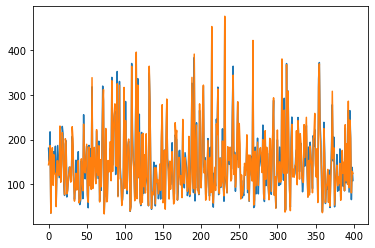

In [6]:
for i in range(400):

    def flight_arrival(env):
        global flight_arrived
        while True:
            yield env.timeout(random.expovariate(1/60))
            flight_arrived.succeed()
            flight_arrived = simpy.Event(env)
            # yield env.process(flight_arrival(env))


    class Passenger:
        global local_counters, foreign_counters

        def __init__(self, env, type, flight_num, i):
            self.env = env
            self.type = type
            self.id = i
            self.flight_id = flight_num
            env.process(self.Behaviour())

        def Behaviour(self):
            yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
            # print("Time:%.2f" % self.env.now, "Passenger", self.id,
            #     "from flight", self.flight_id, "arrived in queue.")
            if (self.type == "local"):
                yield self.env.process(self.localCustomerArrival())
            else:
                yield self.env.process(self.foreignCustomerArrival())
            # yield self.env.process(self.counter_arrival(self.env))

        def localCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with local_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_local += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at local counter.")
                localPassenger += 1
                yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")

        def foreignCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with foreign_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_foreign += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at foreign counter.")
                foreignPassenger += 1
                yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")


    def flight_passengers(env):
        global W_local, W_foreign, localPassenger, foreignPassenger
        flight_num = 0
        while True:
            flight_num += 1
            yield flight_arrived
            # print("Flight", flight_num, "arrived at %.2f" % env.now)

            passengers_count = random.randint(
                numOfPeople[0], numOfPeople[1])
            for i in range(passengers_count):
                P_Local = random.uniform(0, 1)
                if (P_Local < 2/3):
                    Passenger_type = "local"
                else:
                    Passenger_type = "foreign"
                Passenger(env, Passenger_type, flight_num, i)


    
    env = simpy.Environment()

    W_local = 0
    W_foreign = 0


    localPassenger = 0
    foreignPassenger = 0

    foreign_queue = []
    local_queue = []


    class MonitoredResource(simpy.Resource):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.data = []

        def request(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().request(*args, **kwargs)

        def release(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().release(*args, **kwargs)


    foreign_counters = MonitoredResource(env, capacity=foreignCounter)
    local_counters = MonitoredResource(env, capacity=localCounter)

    flight_arrived = simpy.Event(env)

    passengers_flight_proc = env.process(flight_passengers(env))
    flight_arrival_proc = env.process(flight_arrival(env))

    env.run(until=timeOfSimultion)

    Local_avg_400.append(W_local/localPassenger)
    Foreign_avg_400.append(W_foreign/foreignPassenger)


    
plt.plot(Local_avg_400, label="local")
plt.plot(Foreign_avg_400, label="foreign")
plt.show()


In [7]:
import numpy as np
import scipy.stats as st
print("Estimated value of W for n=400", np.mean(Local_avg_400))
# 95% confidence interval

print("95% confidence interval for W for n=400: ", end="")
st.t.interval(0.95, len(Local_avg_400)-1, loc=np.mean(
    Local_avg_400), scale=st.sem(Local_avg_400))


Estimated value of W for n=400 148.35957000514557
95% confidence interval for W for n=400: 

(140.7861475578321, 155.93299245245905)

**Simulation for n = 1600**

In [8]:


for i in range(1600):

    def flight_arrival(env):
        global flight_arrived
        while True:
            yield env.timeout(random.expovariate(1/60))
            flight_arrived.succeed()
            flight_arrived = simpy.Event(env)
            # yield env.process(flight_arrival(env))


    class Passenger:
        global local_counters, foreign_counters

        def __init__(self, env, type, flight_num, i):
            self.env = env
            self.type = type
            self.id = i
            self.flight_id = flight_num
            env.process(self.Behaviour())

        def Behaviour(self):
            yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
            # print("Time:%.2f" % self.env.now, "Passenger", self.id,
            #     "from flight", self.flight_id, "arrived in queue.")
            if (self.type == "local"):
                yield self.env.process(self.localCustomerArrival())
            else:
                yield self.env.process(self.foreignCustomerArrival())
            # yield self.env.process(self.counter_arrival(self.env))

        def localCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with local_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_local += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at local counter.")
                localPassenger += 1
                yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")

        def foreignCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with foreign_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_foreign += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at foreign counter.")
                foreignPassenger += 1
                yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")


    def flight_passengers(env):
        global W_local, W_foreign, localPassenger, foreignPassenger
        flight_num = 0
        while True:
            flight_num += 1
            yield flight_arrived
            # print("Flight", flight_num, "arrived at %.2f" % env.now)

            passengers_count = random.randint(
                numOfPeople[0], numOfPeople[1])
            for i in range(passengers_count):
                P_Local = random.uniform(0, 1)
                if (P_Local < 2/3):
                    Passenger_type = "local"
                else:
                    Passenger_type = "foreign"
                Passenger(env, Passenger_type, flight_num, i)


    
    env = simpy.Environment()

    W_local = 0
    W_foreign = 0


    localPassenger = 0
    foreignPassenger = 0

    foreign_queue = []
    local_queue = []


    class MonitoredResource(simpy.Resource):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.data = []

        def request(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().request(*args, **kwargs)

        def release(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().release(*args, **kwargs)


    foreign_counters = MonitoredResource(env, capacity=foreignCounter)
    local_counters = MonitoredResource(env, capacity=localCounter)

    flight_arrived = simpy.Event(env)

    passengers_flight_proc = env.process(flight_passengers(env))
    flight_arrival_proc = env.process(flight_arrival(env))
    
    env.run(until=timeOfSimultion)

    Local_avg_1600.append(W_local/localPassenger)
    Foreign_avg_1600.append(W_foreign/foreignPassenger)


plt.plot(Local_avg_1600, label="local")
plt.plot(Foreign_avg_1600, label="foreign")
plt.show()


In [ ]:
import numpy as np
import scipy.stats as st
print("Estimated value of W for n=1600", np.mean(Local_avg_1600))
# 95% confidence interval

print("95% confidence interval for W for n=1600: ", end="")
st.t.interval(0.95, len(Local_avg_1600)-1, loc=np.mean(
    Local_avg_1600), scale=st.sem(Local_avg_1600))


Estimated value of W for n=1600 148.0663610582869
95% confidence interval for W for n=1600: 

(144.2526387045291, 151.8800834120447)

**Observation:**<br>
1. Confidence interval range decreases as n increases.

**Part 3b:**

![Calculation](Assignment_4_confidence_interval_calculation.jpeg)

In [ ]:
mu = np.mean(Local_avg_1600)
sigma = np.std(Local_avg_1600)

In [ ]:
number_of_simulations = ((1.96*sigma*100)/(mu))**2

In [ ]:
number_of_simulations

10592.343186974582

In [ ]:
avg_waiting_time_local_arr_final = []
avg_waiting_time_foreign_arr_final = []


**W within a ±1% precision with 95% accuracy**

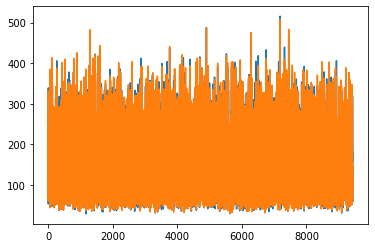

In [ ]:


for i in range(9435):

    def flight_arrival(env):
        global flight_arrived
        while True:
            yield env.timeout(random.expovariate(1/60))
            flight_arrived.succeed()
            flight_arrived = simpy.Event(env)
            # yield env.process(flight_arrival(env))

    class Passenger:
        global local_counters, foreign_counters

        def __init__(self, env, type, flight_num, i):
            self.env = env
            self.type = type
            self.id = i
            self.flight_id = flight_num
            env.process(self.Behaviour())

        def Behaviour(self):
            yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
            # print("Time:%.2f" % self.env.now, "Passenger", self.id,
            #     "from flight", self.flight_id, "arrived in queue.")
            if (self.type == "local"):
                yield self.env.process(self.localCustomerArrival())
            else:
                yield self.env.process(self.foreignCustomerArrival())
            # yield self.env.process(self.counter_arrival(self.env))

        def localCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with local_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_local += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at local counter.")
                localPassenger += 1
                yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")

        def foreignCustomerArrival(self):
            global localPassenger, foreignPassenger, W_local, W_foreign
            with foreign_counters.request() as req:
                wait_time_start = self.env.now
                yield req
                W_foreign += self.env.now - wait_time_start
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "arrived at foreign counter.")
                foreignPassenger += 1
                yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger",
                #     self.id, "done immigration.")

    def flight_passengers(env):
        global W_local, W_foreign, localPassenger, foreignPassenger
        flight_num = 0
        while True:
            flight_num += 1
            yield flight_arrived
            # print("Flight", flight_num, "arrived at %.2f" % env.now)

            passengers_count = random.randint(
                numOfPeople[0], numOfPeople[1])
            for i in range(passengers_count):
                P_Local = random.uniform(0, 1)
                if (P_Local < 2/3):
                    Passenger_type = "local"
                else:
                    Passenger_type = "foreign"
                Passenger(env, Passenger_type, flight_num, i)

    env = simpy.Environment()

    W_local = 0
    W_foreign = 0

    localPassenger = 0
    foreignPassenger = 0

    foreign_queue = []
    local_queue = []

    class MonitoredResource(simpy.Resource):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.data = []

        def request(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().request(*args, **kwargs)

        def release(self, *args, **kwargs):
            self.data.append((self._env.now, len(self.queue)))
            return super().release(*args, **kwargs)

    foreign_counters = MonitoredResource(env, capacity=foreignCounter)
    local_counters = MonitoredResource(env, capacity=localCounter)

    flight_arrived = simpy.Event(env)

    passengers_flight_proc = env.process(flight_passengers(env))
    flight_arrival_proc = env.process(flight_arrival(env))

    env.run(until=timeOfSimultion)

    avg_waiting_time_local_arr_final.append(W_local/localPassenger)
    avg_waiting_time_foreign_arr_final.append(W_foreign/foreignPassenger)

    
plt.plot(avg_waiting_time_local_arr_final, label="local")
plt.plot(avg_waiting_time_foreign_arr_final, label="foreign")
plt.show()


In [ ]:
import scipy.stats as st
import numpy as np
# 95% confidence interval
st.t.interval(0.95, len(avg_waiting_time_foreign_arr_final)-1, loc=np.mean(
    avg_waiting_time_foreign_arr_final), scale=st.sem(avg_waiting_time_foreign_arr_final))


(147.60550823770126, 150.68377087254885)

Confidence interval range has decreased down to 3 units

In [ ]:
np.mean(avg_waiting_time_foreign_arr_final)

149.14463955512505

In [ ]:
np.std(avg_waiting_time_foreign_arr_final)

76.26403816813122

**Part 4**<br>
Running the simulation 9435 times for different values of m

In [ ]:
for m in range(3, 100):
    avg_waiting_time_foreign_arr = []


    for i in range(9435):

        def flight_arrival(env):
            global flight_arrived
            while True:
                yield env.timeout(random.expovariate(1/60))
                flight_arrived.succeed()
                flight_arrived = simpy.Event(env)
                # yield env.process(flight_arrival(env))

        class Passenger:
            global local_counters, foreign_counters

            def __init__(self, env, type, flight_num, i):
                self.env = env
                self.type = type
                self.id = i
                self.flight_id = flight_num
                env.process(self.Behaviour())

            def Behaviour(self):
                yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger", self.id,
                #     "from flight", self.flight_id, "arrived in queue.")
                if (self.type == "local"):
                    yield self.env.process(self.localCustomerArrival())
                else:
                    yield self.env.process(self.foreignCustomerArrival())
                # yield self.env.process(self.counter_arrival(self.env))

            def localCustomerArrival(self):
                global localPassenger, foreignPassenger, W_local, W_foreign
                with local_counters.request() as req:
                    wait_time_start = self.env.now
                    yield req
                    W_local += self.env.now - wait_time_start
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "arrived at local counter.")
                    localPassenger += 1
                    yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "done immigration.")

            def foreignCustomerArrival(self):
                global localPassenger, foreignPassenger, W_local, W_foreign
                with foreign_counters.request() as req:
                    wait_time_start = self.env.now
                    yield req
                    W_foreign += self.env.now - wait_time_start
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "arrived at foreign counter.")
                    foreignPassenger += 1
                    yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "done immigration.")

        def flight_passengers(env):
            global W_local, W_foreign, localPassenger, foreignPassenger
            flight_num = 0
            while True:
                flight_num += 1
                yield flight_arrived
                # print("Flight", flight_num, "arrived at %.2f" % env.now)

                passengers_count = random.randint(
                    numOfPeople[0], numOfPeople[1])
                for i in range(passengers_count):
                    P_Local = random.uniform(0, 1)
                    if (P_Local < 2/3):
                        Passenger_type = "local"
                    else:
                        Passenger_type = "foreign"
                    Passenger(env, Passenger_type, flight_num, i)

        env = simpy.Environment()

        W_local = 0
        W_foreign = 0

        localPassenger = 0
        foreignPassenger = 0

        foreign_queue = []
        local_queue = []

        class MonitoredResource(simpy.Resource):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.data = []

            def request(self, *args, **kwargs):
                self.data.append((self._env.now, len(self.queue)))
                return super().request(*args, **kwargs)

            def release(self, *args, **kwargs):
                self.data.append((self._env.now, len(self.queue)))
                return super().release(*args, **kwargs)

        foreign_counters = MonitoredResource(env, capacity=m)
        local_counters = MonitoredResource(env, capacity=localCounter)

        flight_arrived = simpy.Event(env)

        passengers_flight_proc = env.process(flight_passengers(env))
        flight_arrival_proc = env.process(flight_arrival(env))

        # monitor = partial(monitor, local_queue)
        # patch_resource(local_counters, post = monitor)

        # env.process(flight_arrival(env))
        env.run(until=timeOfSimultion)
        avg_waiting_time_foreign_arr.append(W_foreign/foreignPassenger)

    print("m: ", m, np.mean(avg_waiting_time_foreign_arr))


m:  3 53.711178463929286
m:  4 28.09264027498399
m:  5 17.897112824776112
m:  6 12.867083365713635
m:  7 9.617956466066316
m:  8 7.542193911788632
m:  9 6.032945490973783
m:  10 4.938043069600146
m:  11 4.102101513528567
m:  12 3.4134741564384607
m:  13 2.882037509879173


KeyboardInterrupt: 

Interuppted simulation because it was taking huge amount of time (5-6 hours).

**Observation: For m = 7, W reduces to 9.6 for foreign**

Running the simulation 9435 times for different values of n

In [ ]:
for n in range(2, 100):
    avg_waiting_time_local_arr = []

    for i in range(9435):

        def flight_arrival(env):
            global flight_arrived
            while True:
                yield env.timeout(random.expovariate(1/60))
                flight_arrived.succeed()
                flight_arrived = simpy.Event(env)
                # yield env.process(flight_arrival(env))

        class Passenger:
            global local_counters, foreign_counters

            def __init__(self, env, type, flight_num, i):
                self.env = env
                self.type = type
                self.id = i
                self.flight_id = flight_num
                env.process(self.Behaviour())

            def Behaviour(self):
                yield self.env.timeout(random.uniform(walkingTime[0], walkingTime[1]))
                # print("Time:%.2f" % self.env.now, "Passenger", self.id,
                #     "from flight", self.flight_id, "arrived in queue.")
                if (self.type == "local"):
                    yield self.env.process(self.localCustomerArrival())
                else:
                    yield self.env.process(self.foreignCustomerArrival())
                # yield self.env.process(self.counter_arrival(self.env))

            def localCustomerArrival(self):
                global localPassenger, foreignPassenger, W_local, W_foreign
                with local_counters.request() as req:
                    wait_time_start = self.env.now
                    yield req
                    W_local += self.env.now - wait_time_start
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "arrived at local counter.")
                    localPassenger += 1
                    yield self.env.timeout(random.uniform(localCounterTime[0], localCounterTime[1]))
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "done immigration.")

            def foreignCustomerArrival(self):
                global localPassenger, foreignPassenger, W_local, W_foreign
                with foreign_counters.request() as req:
                    wait_time_start = self.env.now
                    yield req
                    W_foreign += self.env.now - wait_time_start
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "arrived at foreign counter.")
                    foreignPassenger += 1
                    yield self.env.timeout(random.uniform(foreignCounterTime[0], foreignCounterTime[1]))
                    # print("Time:%.2f" % self.env.now, "Passenger",
                    #     self.id, "done immigration.")

        def flight_passengers(env):
            global W_local, W_foreign, localPassenger, foreignPassenger
            flight_num = 0
            while True:
                flight_num += 1
                yield flight_arrived
                # print("Flight", flight_num, "arrived at %.2f" % env.now)

                passengers_count = random.randint(
                    numOfPeople[0], numOfPeople[1])
                for i in range(passengers_count):
                    P_Local = random.uniform(0, 1)
                    if (P_Local < 2/3):
                        Passenger_type = "local"
                    else:
                        Passenger_type = "foreign"
                    Passenger(env, Passenger_type, flight_num, i)

        

        env = simpy.Environment()

        W_local = 0
        W_foreign = 0

        localPassenger = 0
        foreignPassenger = 0

        foreign_queue = []
        local_queue = []

        class MonitoredResource(simpy.Resource):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.data = []

            def request(self, *args, **kwargs):
                self.data.append((self._env.now, len(self.queue)))
                return super().request(*args, **kwargs)

            def release(self, *args, **kwargs):
                self.data.append((self._env.now, len(self.queue)))
                return super().release(*args, **kwargs)

        foreign_counters = MonitoredResource(env, capacity=7)
        local_counters = MonitoredResource(env, capacity=n)

        flight_arrived = simpy.Event(env)

        passengers_flight_proc = env.process(flight_passengers(env))
        flight_arrival_proc = env.process(flight_arrival(env))

        
        env.run(until=timeOfSimultion)
        avg_waiting_time_local_arr.append(W_local/localPassenger)
    print("n: ", n, np.mean(avg_waiting_time_local_arr))


n:  2 148.60689058445965
n:  3 54.045601406013255
n:  4 28.360839537302013
n:  5 18.206425711451324
n:  6 13.041327799238108
n:  7 9.933052114024152
n:  8 7.789708467533124
n:  9 6.2693268450318245
n:  10 5.190453502379563
n:  11 4.315575720980313


KeyboardInterrupt: 

Interuppted simulation because it was taking huge amount of time (5-6 hours).

**Observation: For n = 7, W reduces to 9.33 for local**

<center> Thanks for reading </center>